!pip install connectivipy

!pip install pyEDFlib

!pip install networkx

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
import numpy as np
import pyedflib
import pandas as pd
import connectivipy as cp

In [3]:
file_name= 'S038R01.edf'

In [4]:
def read_data_file(file):
    f = pyedflib.EdfReader(file)
    
    n = f.signals_in_file
    #signal_labels = f.getSignalLabels()
    signal_labels = [name.replace(".","") for name in f.getSignalLabels()]
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    #data=pd.DataFrame(sigbufs).T
    #data.columns=signal_labels
    return signal_labels,sigbufs

In [5]:
labels, data = read_data_file(file_name)

1.1 (mandatory) Estimate functional brain connectivity among 64 channels using one of the
MVAR estimators: Partial Directed Coherence (PDC), Direct Transfer Function (DTF). Select
one relevant frequency value. Apply a threshold so that the resulting binary connectivity
matrices have network density equal to 20%. Create a graphical representation of the binary
adjacency matrix.

https://connectivipy.readthedocs.io/en/latest/tutorial.html

In [6]:
len(labels)

64

In [143]:
def estimation_1(data, nrepp):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    dtf_values = dt.conn('dtf')
    dtf_significance = dt.significance(Nrep=nrepp, alpha=0.05)
    return dtf_significance

In [80]:
def estimation_2(data, freq):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    dtf = cp.conn.dtf_fun(ar, vr, fs=10, resolution=100, generalized=False)[freq,:,:]
    return dtf

In [81]:
def estimation_3(data,freq):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    pdc = cp.conn.pdc_fun(ar, vr, fs=10, resolution=100, generalized=False)[freq,:,:]
    return pdc

In [82]:
def find_T_est_1(significance,density): # i think our graph will be directed, 
    #but in case if it is undirected the we need to change formula
    total_num = significance.shape[0]*significance.shape[1]
    k = significance.shape[0]
    n = int( density*total_num+k)
    T = sorted(significance.flatten())[-n]
    return T

In [89]:
def build_adj(est, T):
    adj = 1*(est>T)
    return adj

In [85]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

In [124]:
def build_graph(adj,labels):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    Edges = [(labels[idx_i[i]],labels[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    our_graph=nx.DiGraph()
    our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(16,16)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

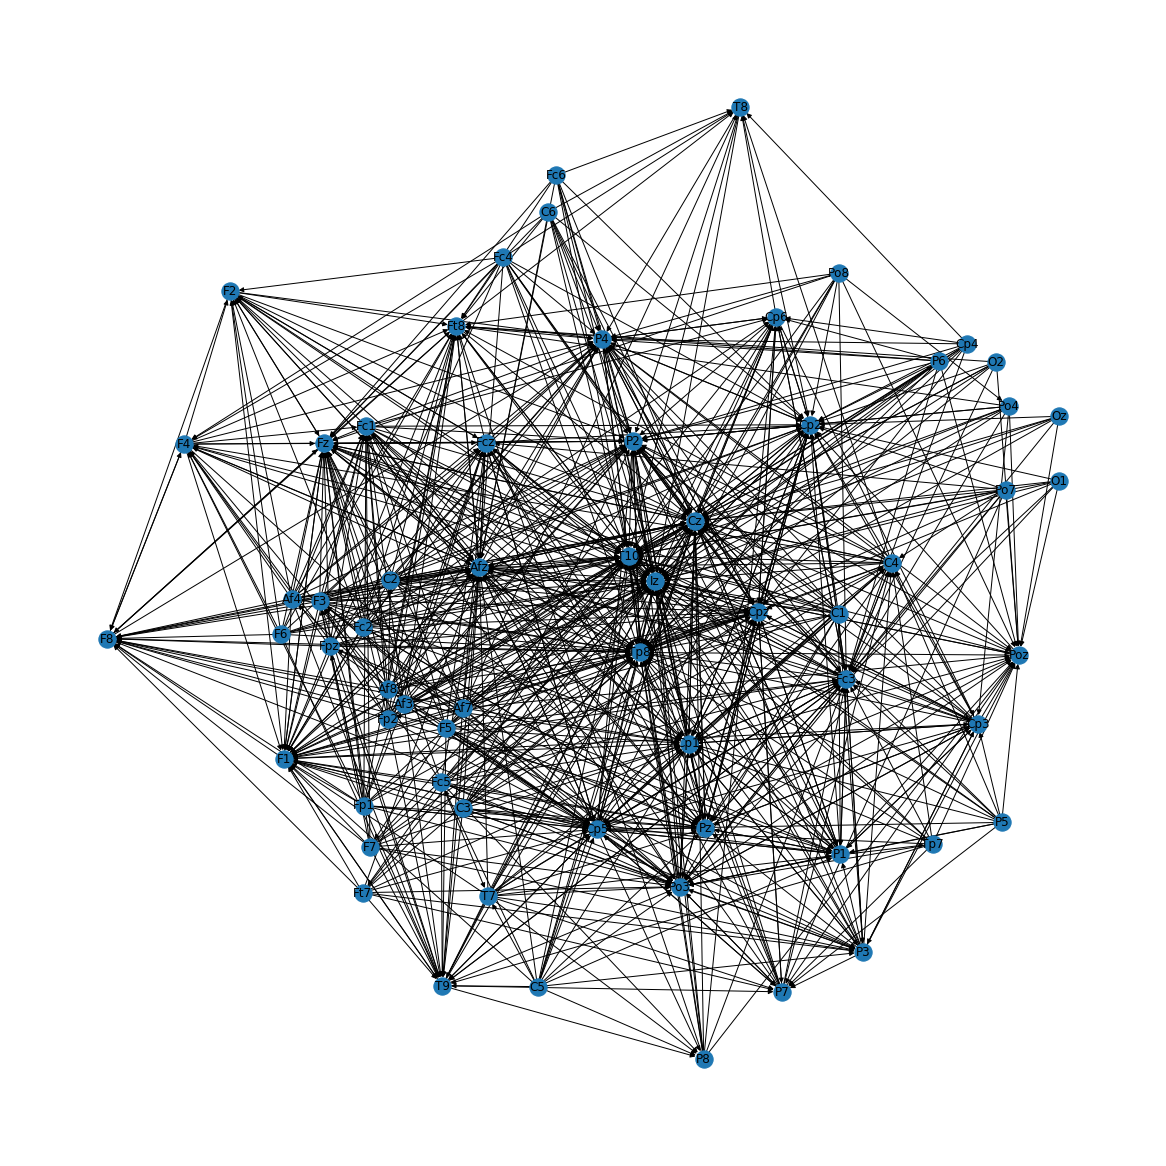

In [136]:
dtf= estimation_2(data,9)
T= find_T_est_1(dtf,0.2)
adjj= build_adj(dtf, T)
gg= build_graph(adjj,labels)

In [112]:
np.sum(adjj)/(63*64) # check density

0.21875

# 1.2
(class ‘A’) Perform task 1.1 using both estimators (PDC and DTF).

False


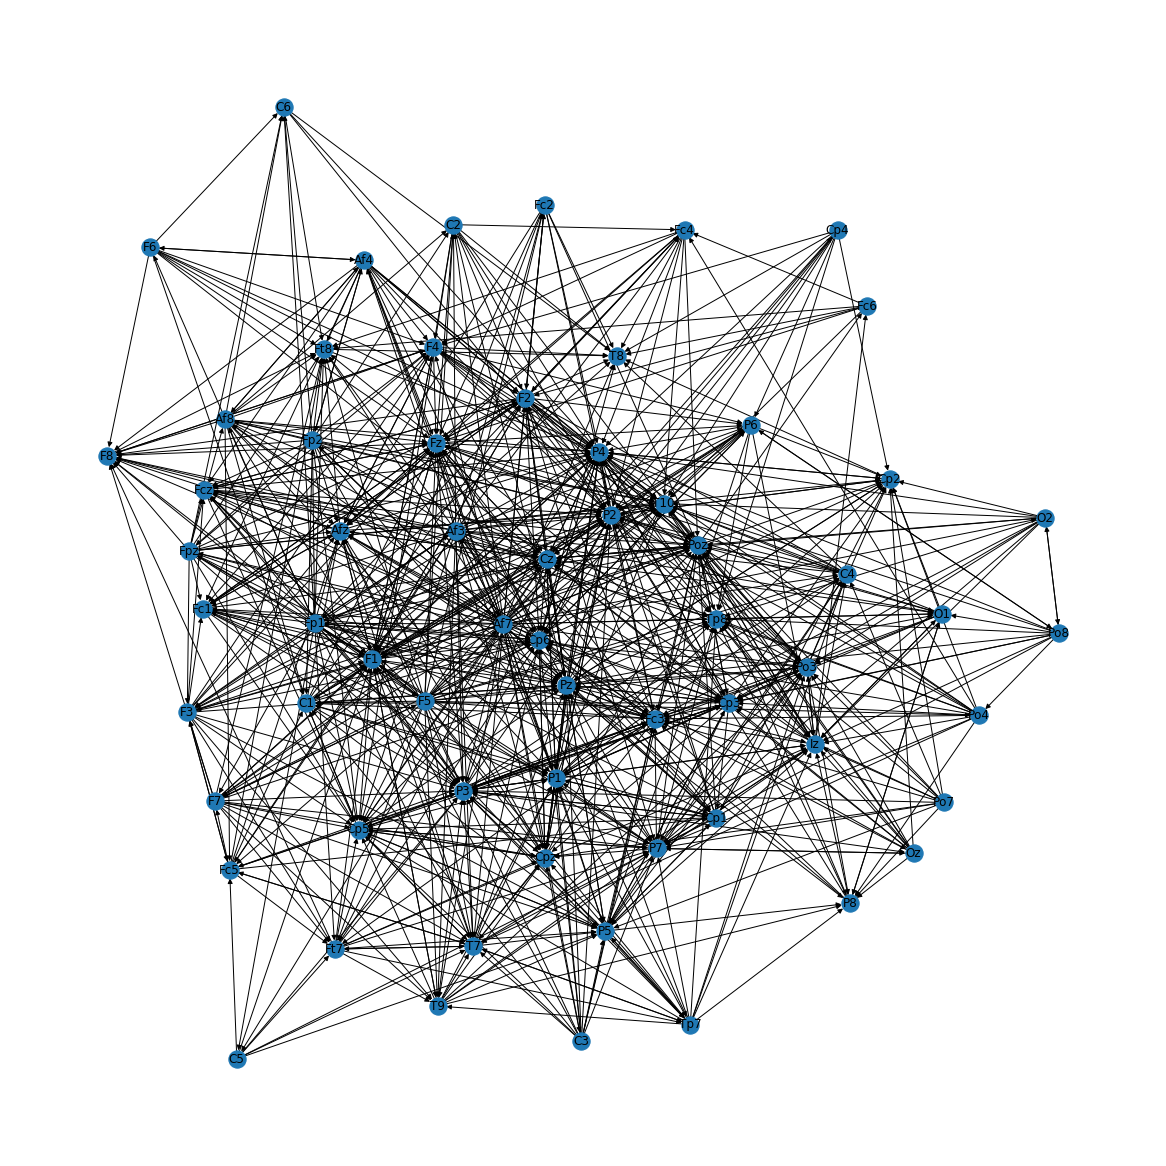

In [137]:
pdc= estimation_3(data,9) # second approach

T= find_T_est_1(pdc,0.2)
adjj= build_adj(pdc, T)
print(check_symmetric(adjj))
gg1= build_graph(adjj,labels)

# 1.4.
(class ‘D’) Considering the subset of 19 channels suggested in Figure 1 and Table 2, estimate
the connectivity using PDC or DTF and apply a statistical validation method (asymptotic
statistics 7 , resampling procedure 8 ,...) to filter out values that are not significantly different
from 0 (PDC(i, j) ≠ 0 with p < 5%)

In [142]:
sub_labels=['Fp1','Fp2','F7','F3','Fz','F4','F8','T7','C3','Cz','C4','T8','P7','P3','Pz','P4','P8','O1',\
            'O2']
idx_labels=[labels.index(sub_labels[i]) for i in range(19)]
sub_data = data[idx_labels,]

In [145]:
sign_19= estimation_1(sub_data, 100) # in this procedure is already specified alpha=0.05

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


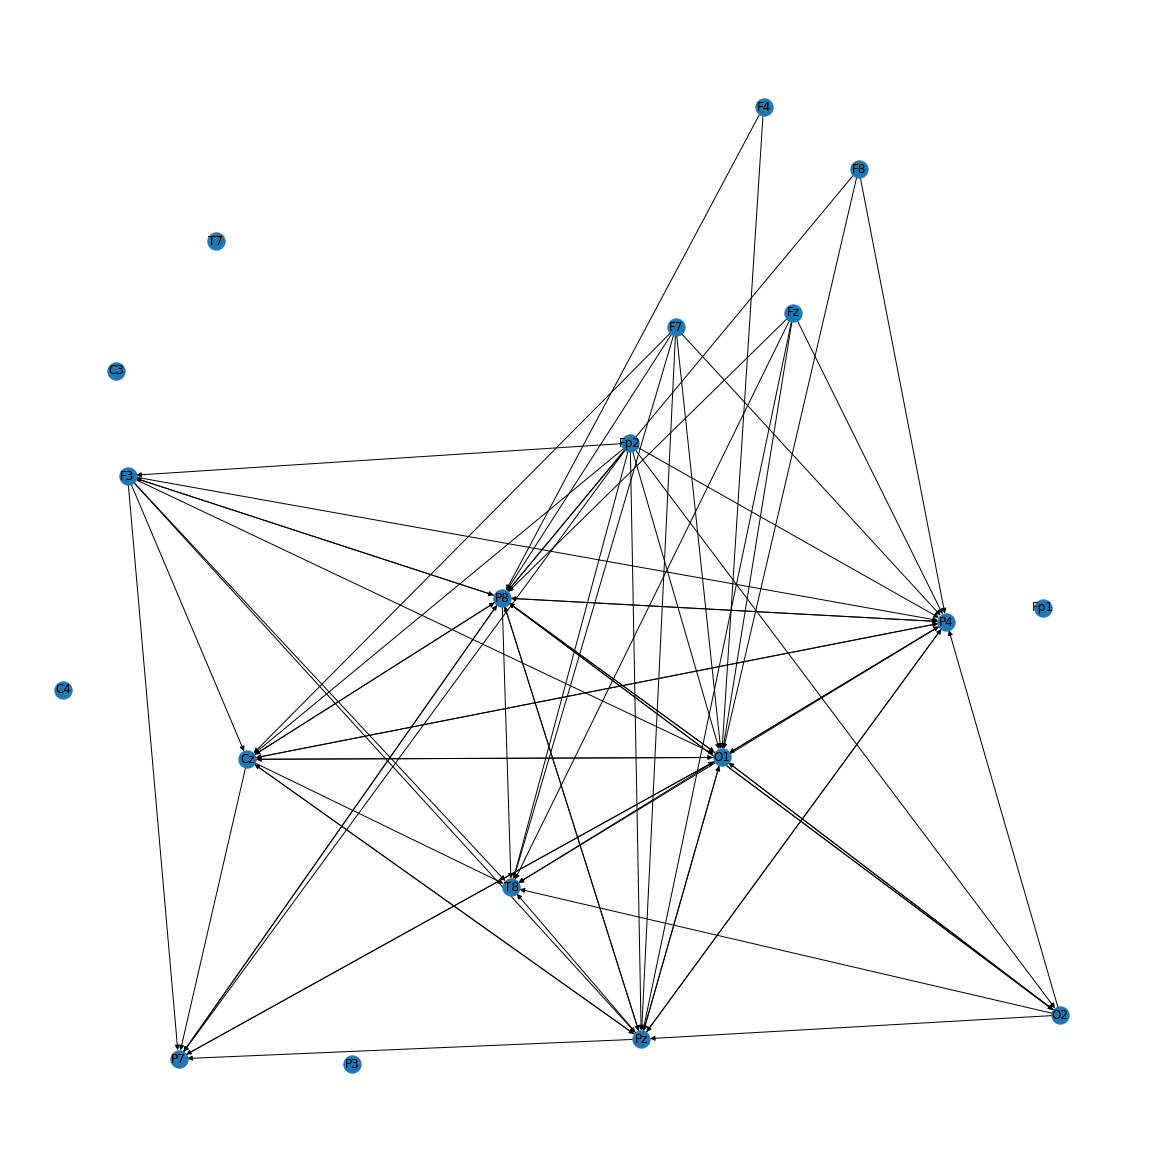

In [148]:
T= find_T_est_1(sign_19,0.2)
adjj= build_adj(sign_19, T)
gg2= build_graph(adjj,sub_labels)

# 1.5
(class ‘C’) Make a topographical representation of the networks (see example in Figure 2).
Cartesian coordinates of planar representation of EEG channels are available in Table 3 (see
also the file channel_locations.txt).
(the choice of this task is advised in the case of 19-channel networks and/or density ≤ 5%).